In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import os
import folium
from sum_money import *
%load_ext autoreload
%autoreload 2

# Amount of money received per canton

In this notebook, we first need to compute the Amount of money received per canton and then we will do the Vizualisation. 

The functions used in this notebook are implemented in amount_sum.py file.

## Load P3 data

We load the JSON file prepared in the Notebook *University_to_Canton.ipynb* and we transform it into a pandas DataFrame

In [3]:
# load cantons dictionnary from JSON file
with open('data/cantons.json', 'r') as ff:
    cantons = json.load(ff)
    
# load df DataFrame of P3 database
df = pd.read_csv('data/P3_GrantExport.csv', header=0, sep=';')
df = df.fillna('')

## Clean P3 data

We need to clean the *fail* entries in the DataFrame and need to deal with some strange values.

In [4]:
# Remove the `fail` entry
del cantons['fail']

# Deal the strange value in `Approved Amount` field
df.loc[df['Approved Amount'] == 'data not included in P3', 'Approved Amount'] = 0
# Convert `Approved Amount` to float type
df['Approved Amount']= df['Approved Amount'].astype(float)


## Assign total amount assigned to each canton

Now, we want to assign the total amount of grants to each canton. In order to do this, we use the function `sum_by_canton` defined in *sum_money.py*.

In [11]:
from collections import defaultdict

# create a dictionary with canton name and the assigned amount
canton_money = dict()
for i in cantons:
    money = sum_by_canton(df, cantons, i)
    # We just divide by 1 billion each amount to get better ticks in the visualization
    money = money/1e9
    canton_money[i] = float(money)

# deal with missing canton (ie the ones that doesn't receive any money)
# default dictionnary
canton_money = defaultdict(lambda: 0, canton_money)

# Map Vizualization

Now, we want to do a *Beautiful* vizualisation! First, we decided to convert the topojson file to a geojson because it's more practical. We use this github project [jeffpaine.github.io/geojson-topojson](http://jeffpaine.github.io/geojson-topojson/) to do this.

First, we need to load the geojson file for the cantons.

In [12]:
# load GeoJson of swiss canton
canton_topo = json.load(open('data/ch-canton.geojson.json'))

Now, we need to create the colormap for the visualization. We already know that the minimum amount of grant is 0. So, let's check for the other amounts. We plot here an histogram of the grants per canton.

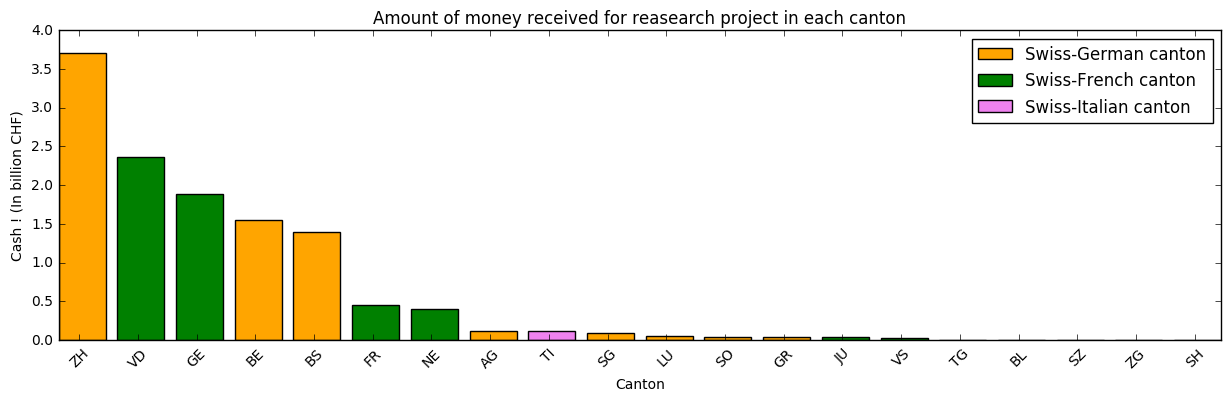

In [13]:
plot_hist_cantons(canton_money, 'Amount of money received for reasearch project in each canton', 'Canton', 'Cash ! (In billion CHF)')

We can see that :
- only Zurich is above 3 billions. 
- Vaud is the only canton between 2 and 3 billions. 
- Geneva, Bern and Basel-Stadt (Basel City) are between 1 and 2 billions.
- Fribourg and Neuchatel are a bit under 0.5 billion. (But above 0.4 billion)
- The rest is under 0.4 billion.
- Some cantons do not have any grant.

So, we decide that we want to create a colormap that will show these 6 categories. In order to do this, we create a `StepColorMap` with categorical colors. We choose in purpose two close colors for the cantons with less than 0.4 billion and between 0.4 and 1 billion.

In [18]:
import folium.colormap as cm

# prepare color line for canton between min and max amount of money
min_ = 0
max_ = max(canton_money.items(), key=lambda a: a[1])[1]

step = cm.StepColormap([(255, 255, 255), (255, 195, 195), 
                        (255, 134, 134),
                        (255, 255, 0), 
                        (0, 255, 0), 
                        (0, 155, 0)],
                       vmin=0, vmax=4, index=[0,0, 0.4, 1, 2, 3, 4],
                       caption='step')

# GitHub could have difficulties to display the map. Please see README.txt to have a quick look at what it looks like.
step

Now, we can show the map with the grants of each canton.

In [19]:
m = folium.Map([46.9,8.4], tiles='cartodbpositron', zoom_start=7.5)

folium.GeoJson(
    canton_topo,
        style_function=lambda feature: {
        'fillColor': step(canton_money[feature['id']]),
        'color': 'black',
        'weight': 2,
        'dashArray': '5, 5'
    }
).add_to(m)

colormap = step
colormap.caption = 'Amount of money assigned for research project (in billion CHF)'
m.add_child(colormap)

m.save(os.path.join('results', 'ch_map.html'))
# GitHub could have difficulties to display the map. Please see README.txt to have a quick look at what it looks like.
m

## Rösti- and Polentagraben (Bonus)

Now, we want to compare each region. The Röstigraben is the "barrier" between French and German speaking people. And the Polentagraben is the barrier between the Italian speaking people and the other. So, we decided to cut between the three linguistic regions. (We also include the Romansh which are a bit the canton called Grison. But they don't have any universities. Grison is considered mostly German speaking.)

In [21]:
swiss_french = ['FR', 'NE', 'VS', 'VD', 'JU', 'GE']
swiss_italien = ['TI']
swiss_german = [i for i in list(canton_money.keys()) if i not in (swiss_french + swiss_italien)]

region_money = dict()
region_money['The \"Welsches\"'] = sum_by_region(df, canton_money, swiss_french)
region_money['The \"Bourbines\"'] = sum_by_region(df, canton_money, swiss_german)
region_money['The \"Ticinesi\"'] = sum_by_region(df, canton_money, swiss_italien)
region_money['The \"Rumantsch\"'] = 0


Now, we can plot an histogram of the grants for each region. Just to help you understand the labels:

- The "Bourbines" are the German-Speaking
- The "Welsches" are the French-Speaking
- The "Ticinesi" are the Italian-Speaking (from the canton Ticino)
- The "Rumantsch" are the Romansh-Speaking

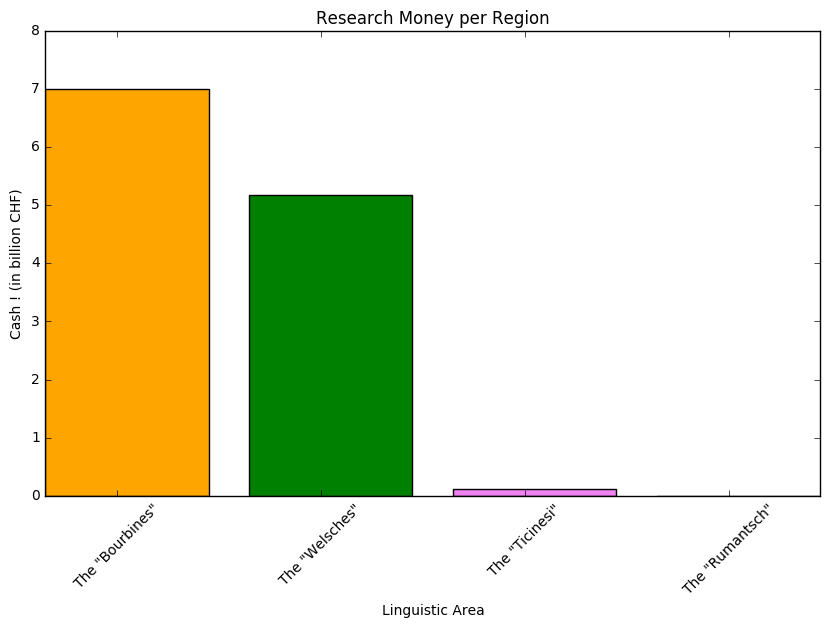

In [24]:
plot_hist_regions(region_money, "Research Money per Region", "Linguistic Area", "Cash ! (in billion CHF)", (10, 6))

Based on this graph we cannot state that there are big differences between Swiss-French and Swiss-German in terms of research investments. At the opposite, if we look at the size of the population in each part, we will probably conclude that there is more investment per person in the Swiss-French part.

We will not comment on the situation of Ticino and Grison.